In [44]:
import argparse
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fftshift, ifftshift
from pyfftw.interfaces.scipy_fftpack import fft2, ifft2,fftn,ifftn

<h2>A clase da seguinte celda implementa un banco de filtros paso banda</h2>

A clase toma como parametros a apertura dos filtros ($\sigma_{f}$), a frecuencia máxima do primeiro filtro do banco, o numero de escalas e a distancia entres filtros de distintas escalas (en oitavas). Empregamos a frecuencia máxima e a distancia entre filtros para calcular a frecuencia central do filtro en cada escala, seguindo a expresión $f_{o}=\frac{f_{max}}{d^s} | s \leq N_{escalas}$. 

Ademais, queremos que o ancho de banda do filtro se manteña constante, xa que filtrará frecuencias máis baixas ou altas en función da súa localización no espectro. Para isto, mantemos a relación entre apertura $\sigma_{f}$ e a frecuencia central $f_{o}$. 

A construción do banco está na función construirBanco, que se chamará desde o resto de métodos cando sexa necesario. Outras funcións implementan o filtrado dunha imaxe empregando o banco, a reconstrución da imaxe a partir das respostas dos filtros, a visualización dos filtros no dominio espacial e de Fourier, a fusión dos resultados do filtrado empregando unha pirámide Laplaciana e o filtrado dun vídeo empregando o banco.

In [28]:
class filtroPasoBanda:

        def __init__(self,sigma,fMax,nscale,d):

            '''Crea o banco de filtros logGaussiana paso banda empregando os parametros: 
                sigmaF ---- apertura do banco en cada escala, empregado para axustar o ancho de banda
                nscale ---- numero de escalas do filtro, as escalas baixas filtran frecuencias altas e as altas frecuencias baixas
                fMax   ---- frecuencia maxima do primeiro filtro do banco, empregase para calcular a frecuencia central do filtro en cada escala
                d      ---- distancia entre filtros de distintas escalas (en oitavas)'''

            self.sigmaF=sigma
            self.fmax=fMax
            self.nscale=nscale
            self.d=d
            self.f0=0.0
            self.filtros=[]
            self.fo_s=[] #almacena as frecuencias centrais de cada escala
            self.BW=0 #ancho de banda dos filtros no banco

            
        def construirBanco(self,shape):
            '''construe o banco de filtros paso banda coas dimensions dunha imaxe ou video empregando os parametros proporcionados,
               esta funcion chamase internamente cando se quere aplicar o filtro, os filtros gardanse na lista self.filtros'''

            #se shape ten valor (w,h), asumimos que é unha imaxe
            if len(shape)==2:
                filas,columnas=shape

                if(columnas%2==0):
                    xvals=np.arange(-(columnas-1)/2.0,((columnas-1)/2.0)+1)/float(columnas-1)

                else:
                    xvals=np.arange(-columnas/2.0,columnas/2.0)/float(columnas)

                if (filas%2):
                    yvals=np.arange(-(filas-1)/2.0,((filas-1)/2.0)+1)/float(filas-1)

                else:
                    yvals=np.arange(-filas/2.0,filas/2.0)/float(filas)

                x,y=np.meshgrid(xvals,yvals,sparse=True)
                radio=np.sqrt(x**2+y**2)
                radio=ifftshift(radio)
                radio[0,0]=1.0

            #se ten shape (w,h,f) é un video, sendo a terceira compoñente o numero de frames, que corresponde
            #con z vals
            elif len(shape)==3:
                filas,columnas,frames=shape

                if(columnas%2==0):
                    xvals=np.arange(-(columnas-1)/2.0,((columnas-1)/2.0)+1)/float(columnas-1)

                else:
                    xvals=np.arange(-columnas/2.0,columnas/2.0)/float(columnas)

                if (filas%2):
                    yvals=np.arange(-(filas-1)/2.0,((filas-1)/2.0)+1)/float(filas-1)

                else:
                    yvals=np.arange(-filas/2.0,filas/2.0)/float(filas)

                if(frames%2):
                    zvals=np.arange(-(frames-1)/2.0,((frames-1)/2.0)+1)/float(frames-1)

                else:
                    zvals=np.arange(-frames/2.0,frames/2.0)/float(frames)

                x,y,z=np.meshgrid(xvals,yvals,zvals,sparse=True)
                radio=np.sqrt(x**2+y**2+z**2)
                radio=ifftshift(radio)
                radio[0,0]=1.0

            for ss in range(self.nscale):
                self.f0=self.fmax/self.d**ss #frecuencia central do filtro
                self.fo_s.append(self.f0)
                
                #novo valor de sigma, para manter constante o ancho de banda nos filtros (relacion sigmaF/f0)
                NsigmaF=self.sigmaF*self.f0

                numerador=np.log(radio/self.f0)
                denominador=2*np.log(NsigmaF/self.f0)**2
                componhente=np.exp(-numerador**2/denominador)
                componhente[0,0]=0.0

                #ancho de banda do filtro, o mesmo en todas as escalas
                self.BW=2*np.sqrt(2/np.log(2))*np.abs(np.log(NsigmaF/self.f0))
                
                self.filtros.append(componhente)
                
            print("\n")
				
        def filtrarImaxe(self,imaxe):

            '''construe un banco de filtros coas dimensions da imaxe e aplicallo, devolve o resultado da filtraxe, tanto a compoñente real como a complexa'''
            self.construirBanco(imaxe.shape)

            resultados=[]
            IM=fft2(imaxe)      		

            for ss in range(self.nscale):
                resultados.append(ifft2(IM*self.filtros[ss]))

            return resultados
		
        def filtrarVideo(self,video):
            '''recibe un argumento de tipo cv2.videoCapture e filtra frame a frame. Neste caso, a propia funcion mostra o resultado da convolucion en cada escala'''

            frames=[]

            while video.isOpened():
                ret,frame=video.read()

                if not ret:
                    break

                frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                frames.append(frame)

            frames=np.array(frames)
            self.construirBanco(frames.shape)
            transform=fftn(frames)
            resultados=[]
            self.filtros=np.array(self.filtros)

            #aplicamoslle cada filtro construido o video
            for filtro in self.filtros:
                print("Aplicando filtro o video")
                resultados.append(ifftn(transform*filtro))

            #para cada resultado de filtraxe mostramos varios frames do video
            num_videos = len(resultados)
            num_frames = 5 #numero de frames que se van amosar de cada video

            fig, axes = plt.subplots(num_videos, num_frames, figsize=(15, 3 * num_videos))

            #para cada video mostramos 5 frames
            for i in range(num_videos):
                video_array = resultados[i]

                for j in range(num_frames):
                    frame_index = int(len(video_array) * j / num_frames)
                    frame = video_array[frame_index]

                    axes[i, j].imshow(np.real(frame),cmap="gray")

                    axes[i,j].set_title("Escala "+str(i))

            plt.show()

        def reconstrucion(self,resultados):
            '''metodo que toma os resultados da fitlraxe e reconstrue a imaxe orixinal, para isto suma as compoñentes reais dos resultados das convolucions nas multiples escalas'''

            originalImage=np.sum(np.real(resultados),axis=0)

            return originalImage

        def fusionImaxe(self,imaxe):

            '''toma os resultados de filtrar a imaxe e fusionaos empregando unha piramide laplaciana'''

            resultados=self.filtrarImaxe(imaxe)
            resultados=np.real(resultados)

            piramideGaussiana=[]
            piramideLaplaciana=[]

            for result in resultados:
                piramideGaussiana.append(cv2.pyrDown(result))

            for i,result in enumerate(resultados[:-1]):

                piramideLaplaciana.append(cv2.subtract(result,cv2.resize(cv2.pyrUp(piramideGaussiana[i+1]),(225,225))))

            piramideLaplaciana.append(cv2.resize(piramideGaussiana[-1],(225,225)))

            imaxeFusionada=np.sum(piramideLaplaciana,axis=0)
            imaxeFusionada=np.clip(imaxeFusionada,0,255).astype(np.uint8)

            plt.imshow(imaxeFusionada,cmap="gray")
            plt.title("Laplaciana")
            plt.show()

        def visualizarFiltros(self):
            '''permite visualizar os filtros no espazo de fourier e no dominio espacial'''

            print("Filtros no dominio de fourier")
            for ss in range(self.nscale):
                plt.subplot((self.nscale // 5) + 1, 5, ss + 1)
                plt.imshow(fftshift(self.filtros[ss]),cmap="gray")
                plt.title(f'Escala {ss + 1}')

            plt.show()

            print("Filtros no dominio espacial")
            for ss in range(self.nscale):
                plt.subplot((self.nscale // 5) + 1, 5, ss + 1)
                plt.imshow(np.abs(fftshift(ifft2((self.filtros[ss])))),cmap="gray")
                plt.title(f'Escala {ss + 1}')

            plt.show()

realizamos 5 probas filtrando a imaxe con distintos parámetros pero o mesmo número de escalas

In [55]:
banco1=filtroPasoBanda(0.5,1/8,7,2)
banco2=filtroPasoBanda(0.8,1/8,7,2)
banco3=filtroPasoBanda(0.8,1/8,7,4)
banco4=filtroPasoBanda(0.4,1/8,7,2)
banco5=filtroPasoBanda(0.7,1,7,2)
imaxe=cv2.imread("../DATA/lenna.png",0)

probas=[]

imFiltradas=banco1.filtrarImaxe(imaxe)
probas.append(imFiltradas)

imFiltradas=banco2.filtrarImaxe(imaxe)
probas.append(imFiltradas)

imFiltradas=banco3.filtrarImaxe(imaxe)
probas.append(imFiltradas)

imFiltradas=banco4.filtrarImaxe(imaxe)
probas.append(imFiltradas)

imFiltradas=banco5.filtrarImaxe(imaxe)
probas.append(imFiltradas)

fCentrais=[banco1.fo_s,banco2.fo_s,banco3.fo_s,banco4.fo_s,banco5.fo_s]
BW=[banco1.BW,banco2.BW,banco3.BW,banco4.BW,banco5.BW]

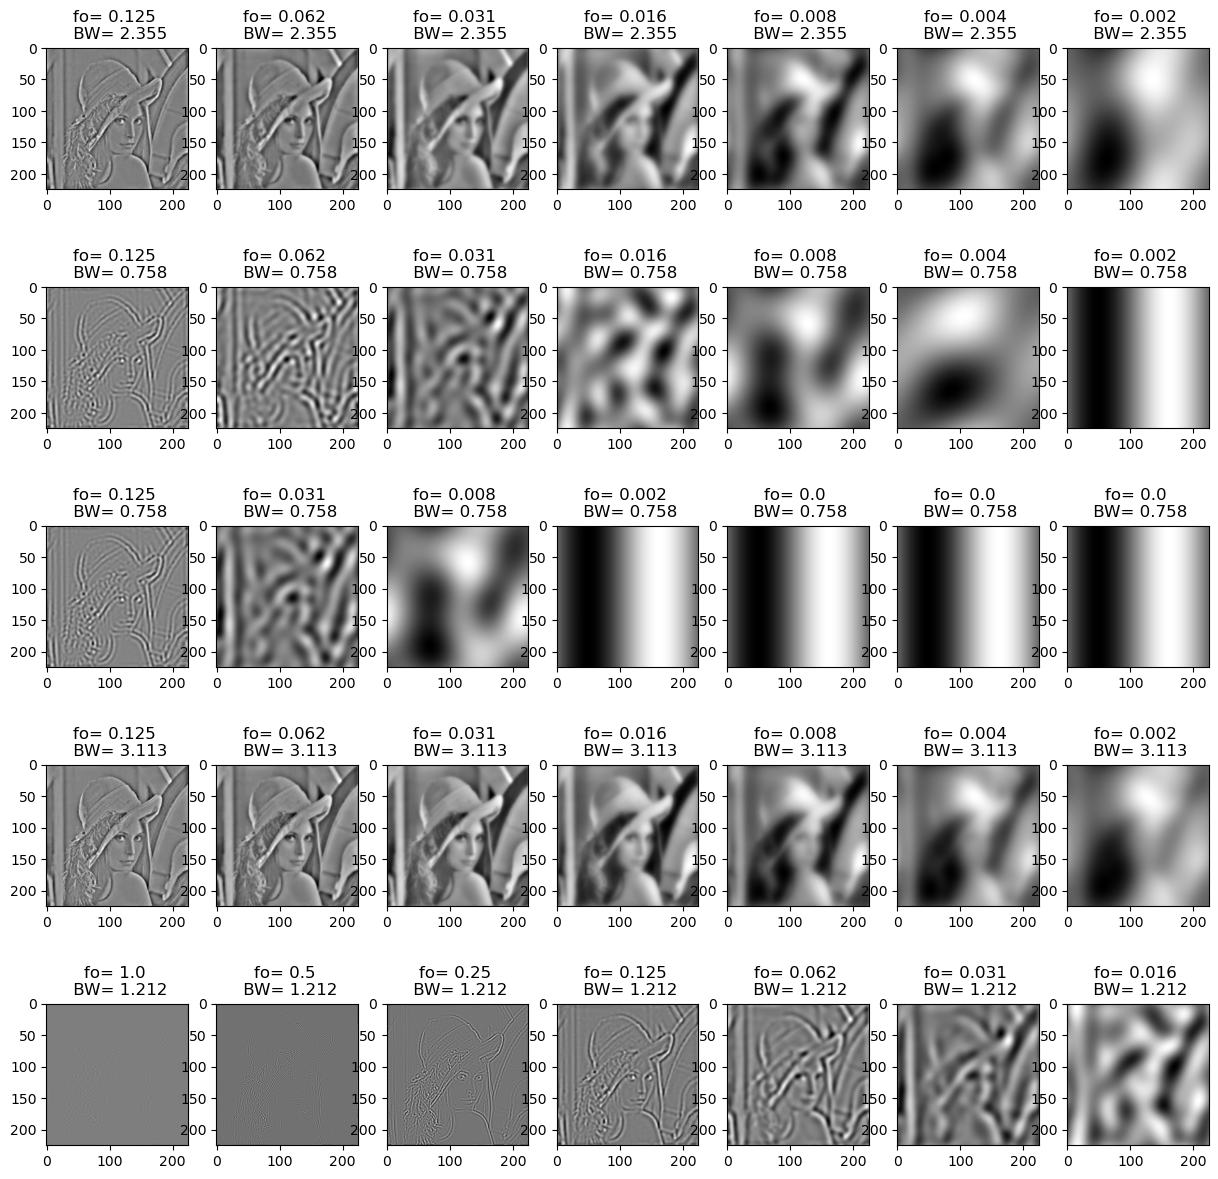

In [56]:
fig=plt.figure(figsize=(15,3*len(probas)))
for i in range(len(probas)):
    for j in range(len(probas[i])):
        plt.subplot(len(probas),len(probas[i]),i*len(probas[i])+j+1)
        plt.imshow(np.real(probas[i][j]),cmap="gray")
        plt.title(f"fo= {round(fCentrais[i][j],3)} \n BW= {round(BW[i],3)}")
    
plt.show()

Na figura anterior, vense os resultados das 5 probas realizadas, cada fila corresponde cunha proba e cada columna cunha escala do banco de filtros.

Vemos que nas primeiras escalas, a frecuencia central está lonxe da orixe do espectro, e que, se o ancho de banda é baixo, filtranse só as frecuencias altas. A medida que a frecuencia central se vai movendo cara a orixe, vanse admitindo máis frecuencias baixas, polo que nas escalas intermedias estanse filtrando ao mesmo tempo frecuencias baixas e altas. Cando o filtro se situa na orixe, actúa como un pasa baixa.

Vemos que un ancho de banda alto fará que o filtro comece filtrando máis frecuencias que só as altas nas primeiras escalas. Se aumentamos o valor de $\sigma_{f}$, redúcese o ancho de banda coas mesmas frecuencias centrais (a relación $\frac{\sigma_{f}}{f_{o}}$ debe permanecer constante), filtrándose de maneira máis efectiva as distintas frecuencias no caso de querer discriminar entre altas e baixas.

Se aumentamos a distancia entre filtros de distintas escalas (proba 3, a distancia cambia de 2 a 4 oitavas, para o resto volve ser 2), filtraranse menos frecuencias intermedias entre as altas e baixas xa que a "transición" de frecuencias centrais entre distintas escalas é máis rápida (na terceira escala, o filtro xa actúa como un paso baixa e nas seguintes estanse filtrando as mesmas frecuencias porque a frecuencia central case non varía).

Finalmente, na proba número 5, aumentamos a frecuencia máxima do primeiro filtro a 1, o que fai que a frecuencia central do mesmo sexa máis alta. Como consecuencia disto, os filtros das primeiras escalas están situados moi cerca do borde da imaxe, isto combinado cun ancho de banda baixo, causará que case non se filtren frecuencias con información relevante nesas escalas.

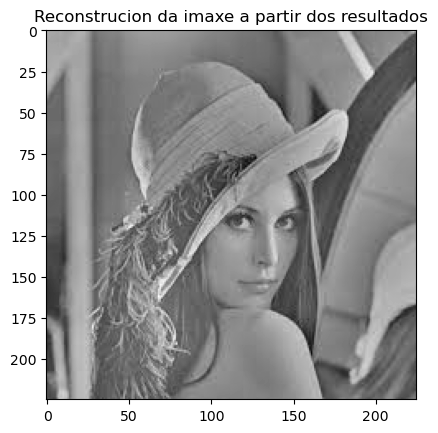

In [57]:
imaxeOrixinal=banco1.reconstrucion(imFiltradas)
plt.imshow(imaxeOrixinal,cmap="gray")
plt.title("Reconstrucion da imaxe a partir dos resultados")
plt.show()

A reconstrucion realizase sumando as partes reais das respostas dos filtros. No caso do filtro paso banda, temos información de todas as frecuencias, polo que a reconstrución será moito máis fiel a imaxe orixinal que co filtro paso baixa.

Filtros no dominio de fourier


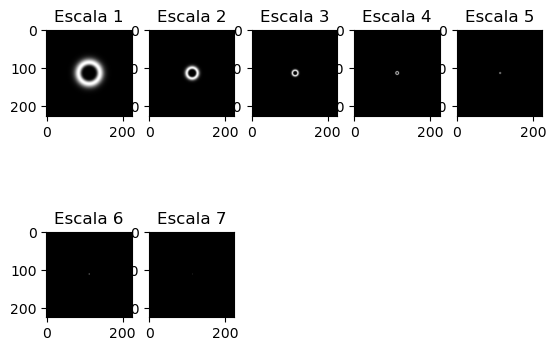

Filtros no dominio espacial


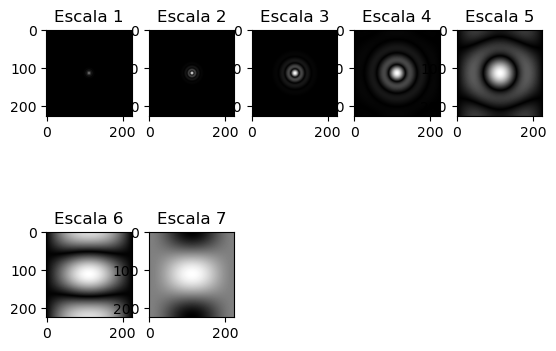

In [50]:
banco2.visualizarFiltros()

Ao visualizar os filtros nos dous espazos, vemos o principio de incerteza frecuencia-tempo que cando está situado nas frecuencias altas, terá menos cobertura no dominio espacial e vice versa.

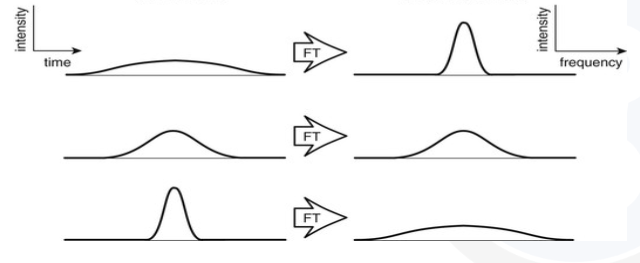

Observamos tamén que o banco está formado por filtros paso banda, que ao convolucionarse coa imaxe filtrarán distintas frecuencias en función da escala.

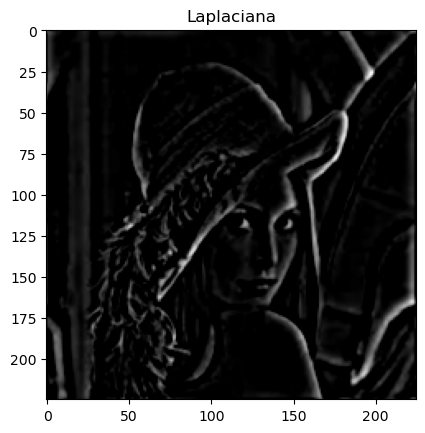

In [58]:
banco1.fusionImaxe(imaxe)

Ao fusionar os resultados do filtrado cunha pirámide Laplaciana combínanse as altas frecuencias da imaxe coas baixas, sendo o resultado unha imaxe correspondente as frecuencias intermedias, na que se manteñen os detalles de alta frecuencia coma os bordes, pero tamén hai información sobre rexións de baixas frecuencias como a cara ou a parede do fondo.

Filtro na escala 0 con centro en 0.125
Ancho de banda na escala 0: 2.3548200450309493
Filtro na escala 1 con centro en 0.0625
Ancho de banda na escala 1: 2.3548200450309493
Filtro na escala 2 con centro en 0.03125
Ancho de banda na escala 2: 2.3548200450309493
Filtro na escala 3 con centro en 0.015625
Ancho de banda na escala 3: 2.3548200450309493
Filtro na escala 4 con centro en 0.0078125
Ancho de banda na escala 4: 2.3548200450309493
Aplicando filtro o video
Aplicando filtro o video
Aplicando filtro o video
Aplicando filtro o video
Aplicando filtro o video


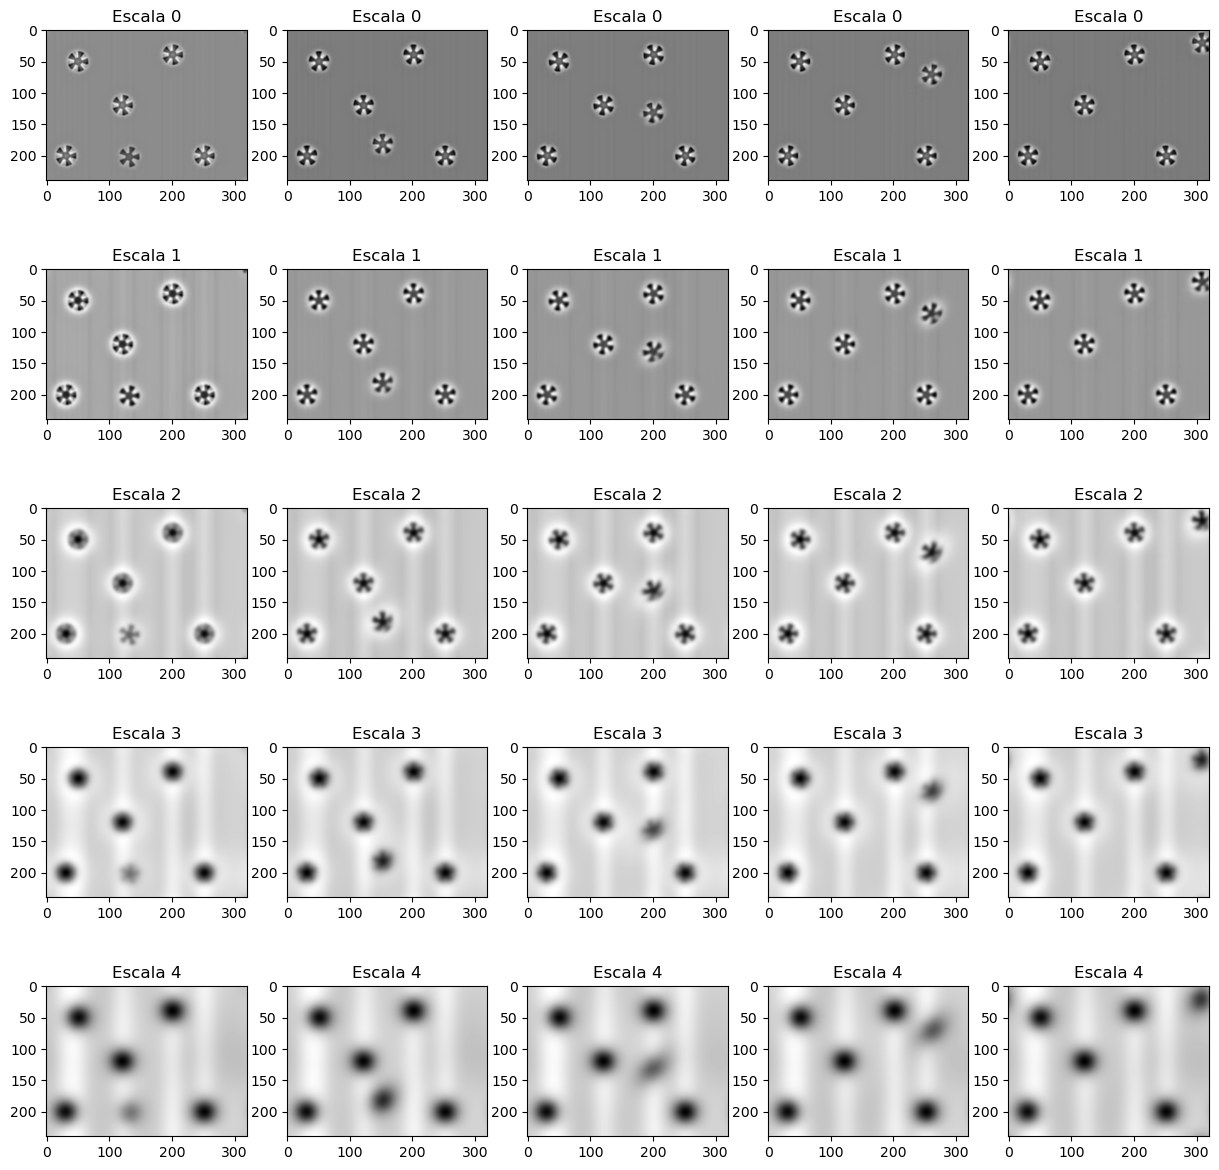

In [4]:
video=cv2.VideoCapture("../DATA/SCE_bur_11_girando.avi")
banco1.filtrarVideo(video)

Aplicando o banco de filtros ao vídeo, observamos o mesmo que para o filtrado de imaxes. Na primeira escala filtranse as altas frecuencias, polo que se distinguen ben as figuras en movemento do fondo, xa que hai un alto contraste entre as mesmas. A medida que se comezan a filtrar frecuencias mais baixas as figuras aparentan ser círculos. Ademais, hai unha figura que se ve con menor intensidade nas frecuencias máis baixas, o que se debe a que a intensidade desa figura é moi similar a do fondo, polo que ao suavizar quedando só coas frecuencias baixas, aparentará unha fusión entre o fondo e a figura ao perderse o detalle dos bordes presente na alta frecuencia.